# Literature review: powered by text mining techniques

🎯 **Goal:** Applying text mining techniques to make a literature review more productive.

🙋 **Author:** Inês G. Gonçalves

📅 **Date:** March 2021

☑️ **Requisites**:
- APIs (see the [requests](https://requests.readthedocs.io/en/master/) library)
- The BioC file type
- Text mining/Natural Language Processing (see the [spaCy](https://spacy.io/) library)
- **Libraries**  `numpy`, `pandas`, `matplotlib`, `seaborn`, `spacy`, `requests`, `biopython`, `bioc`

----

## Integrating text mining tools in a literature review


### A brief introduction to Entity Recognition

**Text mining definition** (according to the [Encyclopedia of Database Systems](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-39940-9_418))
> *Text mining is the art of data mining from text data collections. The goal is to discover knowledge (or information, patterns) from text data, which are unstructured or semi-structured.*"

Text mining is a tool that allows us to **automatically extract specific information** from text. The idea is that we can input an unstructured text file and the mining algorithm will find relevant data and output this information.

Let's start with a simple (and silly) example. We can use [spaCy](https://spacy.io/), a **Natural Language Processing (NLP)** Python library that integrates some pre-trained models and that can perform some of these text mining functions. What happens if we give a model a bunch of random sentences?

- "Joe Biden was elected as President of the US in 2020." 
- "Microsoft was founded by Bill Gates and is now worth 5 billion £."
- "My cat is learning Spanish."
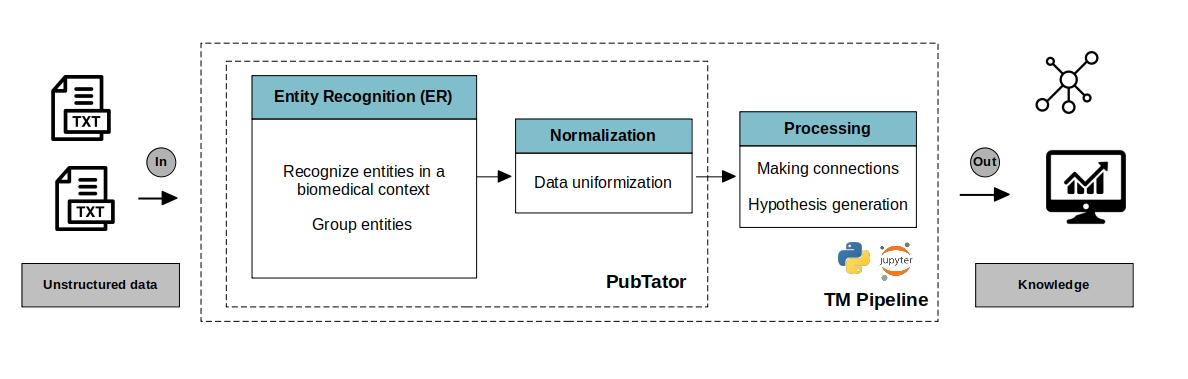

In [359]:
import spacy
from spacy import displacy

# Use the English language model
nlp = spacy.load("en_core_web_sm")

# Run the model with a bunch of sentences
doc = nlp('Joe Biden was elected as President of the US in 2020. \
            \nMicrosoft was founded by Bill Gates and is now worth 5 billion £. \
            \nMy cat is learning Spanish.')

# Display the results in a visual manner
displacy.render(doc, style="ent")

It seems like spaCy knows what some of the words mean! These are called **entities**.

This model of spaCy was trained to recognize certain categories, such as organizations, languages, dates, places,... In addition, it can assign the correct category to each entity. This is called **Named Entity Recognition**.

However, spaCy is just a model, **it doesn't know what every word means**. It **can be trained** to learn about other categories, though. For instance, it doesn't know that a cat is an animal, but if we were to annotate the text and tell that "cat" belongs to a new category "ANIMAL", it could

In [369]:
# Run the model with a bunch of sentences
neuroblastoma_string = nlp('Neuroblastoma is a type of cancer that forms from immature nerve cells.')

# Display the results in a visual manner
displacy.render(neuroblastoma_string, style="ent")

## Gathering data
The first step in our pipeline is to **gather the data that we will be using in the review**.

Here, we can choose one of two options:
- Manually **go into PubMed**, **search** for what we need (using the platform's filters to enhance our search) and **retrieve the PMIDs**;
- **Use Python to automatically perform these actions for us**

We will be implementing the second option, using the [Entrez module form BioPython](https://biopython.org/docs/1.75/api/Bio.Entrez.html).

### The Entrez Python module

The `Entrez.esearch` function is very complete and lets you **filter your search**. Here we will not be looking into all of its functions but here are some examples:
- `max_results`: The maximum number of ids to be retrieved. If this value is not defined, it is set as 20.
- `sort`: Just like in PubMed's platform, you can sort the results by "relevance" (default value), "date" or "journal"
- `mindate`/`maxdate`: Select articles published between two dates. YYYY/MM/DD format should be used, but the function accepts year values.

Let's **start with a small number of articles** to ease our understanding of this module. We will be retrieving **50 PMIDs.**

In [155]:
from Bio import Entrez

query = 'Neuroblastoma'
max_results = 50

# PubMed needs an email that can receive warnings for excessive requests
# (Enter email)
Entrez.email = "..."

handle = Entrez.esearch(db='pubmed',
                        sort='relevance',
                        retmode='xml',
                        retmax=max_results,
                        term=query)

results = Entrez.read(handle)
handle.close()

We now have a data structure with the data retrieved from our query. This is basically a dictionary with meta data such as the **total number of articles** (`Count`) found by the query, the **IDs of the retrieved articles** (`IdList` - this is what we need), and some other information. 

Let's print the keys of the dictionaries to check this. We can also print our **ID list** to confirm that 50 PMIDs were retrieved.

In [157]:
print('Keys in the Entrez dictionary:')
for i, key in enumerate(results.keys()):
    print(f'{i}: {key}')
    
print(f'\nLength of the ID list: {len(results["IdList"])}')

Keys in the Entrez dictionary:
0: Count
1: RetMax
2: RetStart
3: IdList
4: TranslationSet
5: TranslationStack
6: QueryTranslation

Length of the ID list: 50


Everything seems to be working, so **we can move on to passing this data to PubTator**. Before that, let's just **save our IDs** in a file, in case we need them later and don't want to repeat this process.

In [158]:
import numpy as np

# Store the data 
results_ids = results["IdList"]

# Store IDs in a CSV for later use
save_ids = np.array(results_ids)
np.savetxt(f'{query}_raw.csv', save_ids, delimiter=', ', fmt ='%s')

## Processing data with PubTator

> ⚠️ **Attention**: PubMed has a max number of articles for request. I am still trying to learn the best practices to deal with this. PubTator also has this limit, and allows only 100 GET requests at a time. For now, I will be using 100 reports as an example but **the code has to be adapted in order for PubTator to correctly process more 100 IDs.**

### Passing the data to PubTator
Unlike Entrez, **there isn't a Python library that deals with the connection** between our computer and PubTator. Thus, **we need to use its API directly**, using the `requests` package. We only need to know some simple rules for passing data to the platform.

As specified in its [API page]((https://www.ncbi.nlm.nih.gov/research/pubtator/api.html)), PubTator uses the following link structure to access an article:

```
https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/[Format]?[Type]=[Identifiers]&concepts=[Bioconcepts] 
```

- **Format**: The format of the output files (pubtator, biocxml or biocjson)
- **Type**: The type of identifier (pmid or pmcids. You should use pmid for abstracts and pmcids for full text)
- **Identifiers**:The identifier of the article you want to pass. For multiple identifiers, you should pass them separated by a comma
- **Bioconcepts**: The bioconcepts you want to include in your search. If not specified, all bioconcepts will be retrieved (gene, disease, chemical, species, mutation and/or cellline)

Let's try retrieving some of the data from our previous search! We will be using BioCJSON for this example as it is more human-friendly, and we will be looking at only one of the IDs.

In [159]:
import requests

id_type = 'pmids'
export_format = 'biocjson'
id_string = results_ids[0]

# Use PubTator API to retrieve BIOC_XML file type with all bioconcepts
base_url = 'https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/'
url = base_url + f'{export_format}?{id_type}={id_string}&concepts='
session = requests.Session()
pt_response = session.get(url)

# Print out the data from the annotated file
pt_response.json()

{'_id': '32653773|None',
 'id': '32653773',
 'infons': {},
 'passages': [{'infons': {'journal': 'Eur. J. Cancer; 2020 Jul 09 ; 136 52-68. doi:10.1016/j.ejca.2020.05.010',
    'year': '2020',
    'type': 'title',
    'authors': 'Moreno L, Barone G, DuBois SG, Molenaar J, Fischer M, Schulte J, Eggert A, Schleiermacher G, Speleman F, Chesler L, Geoerger B, Hogarty MD, Irwin MS, Bird N, Blanchard GB, Buckland S, Caron H, Davis S, De Wilde B, Deubzer HE, Dolman E, Eilers M, George RE, George S, Jaroslav Š, Maris JM, Marshall L, Merchant M, Mortimer P, Owens C, Philpott A, Poon E, Shay JW, Tonelli R, Valteau-Couanet D, Vassal G, Park JR, Pearson ADJ, ',
    'section': 'Title'},
   'offset': 0,
   'text': 'Accelerating drug development for neuroblastoma: Summary of the Second Neuroblastoma Drug Development Strategy forum from Innovative Therapies for Children with Cancer and International Society of Paediatric Oncology Europe Neuroblastoma.',
   'sentences': [],
   'annotations': [{'id': '5',

So, **we are capable of getting an annotated file with all the information we need**. However, the data is still in a format that is difficult to work with. We can see that there is some meta data and **several annotations**, each with an id, a type, an identifier and text, but how can we **actually use this data?** 

We need to transform it into something we can work with in Python. Thankfully, there is a package for that.

### Parsing the BioCXML files
Since these **BioC files are just XML/JSON files**, we could **use a standard parser** that would transform the data we want to extract into a Python data structure, such as a dictionary. This would take some work, as we would need to identify the keys of the data we desire.

There is a **better solution still**, using the [bioc package](https://pypi.org/project/bioc/), which was built to deal with this data type in particular and that has some useful methods to retrieve the data we need from the files.

Now that we know how the data looks like, we can go back to **using all IDs**. Also, we will be extracting the data in XML, as we do not need to read it.

In [160]:
import bioc

# The API requires the IDs to be separated by a comma
id_string = ','.join(results_ids)
export_format = 'biocxml'

# Use PubTator API to retrieve BIOC_XML file type with all bioconcepts
base_url = 'https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/'
url = base_url + f'{export_format}?{id_type}={id_string}&concepts='
session = requests.Session()
pt_response = session.get(url)

# Load the XML text into a BioCXML file type
bioc_data = bioc.loads(pt_response.text, bioc.BioCFileType.BIOC_XML)

### Getting annotations form the BioC object
One of the advantages of the `bioc` package is the ability to **easily interact with the BioC objects**, using its methods and properties. As an example, let's select one of the articles from our data structure and extract the annotations, printing its text, identifier and type.

In [161]:
first_article = bioc_data.documents[0]

for i, annotation in enumerate(bioc.annotations(first_article)):
    print(annotation.text, annotation.infons)
    
    if i > 4:
        break

children {'identifier': '9606', 'type': 'Species'}
neuroblastoma {'identifier': 'MESH:D009447', 'type': 'Disease'}
Neuroblastoma {'identifier': 'MESH:D009447', 'type': 'Disease'}
children {'identifier': '9606', 'type': 'Species'}
neuroblastoma {'identifier': 'MESH:D009447', 'type': 'Disease'}
Patients {'identifier': '9606', 'type': 'Species'}


With this, we are one step closer to being able to analyze this data. All we need to do now is to **go through our object and extract all of the annotations.**

In [162]:
annotations = []
for annotation in bioc.annotations(bioc_data):
    # Retrieve the text, the identifier (e.g., MESH:...) and the type (bioconcept)
    ann_text = annotation.text
    ann_infons = annotation.infons

    # Some annotations lack an identifier. Set as 'NULL', to be processed later
    if len(list(ann_infons.keys())) > 1:
        ann_identifier = ann_infons[list(ann_infons.keys())[0]]
        ann_type = ann_infons[list(ann_infons.keys())[1]]
    else:
        ann_identifier = 'NULL'
        ann_type = list(ann_infons.keys())[0]

    annotations.append([ann_text, ann_identifier, ann_type])
    
annotations[0:5]

[['children', '9606', 'Species'],
 ['neuroblastoma', 'MESH:D009447', 'Disease'],
 ['Neuroblastoma', 'MESH:D009447', 'Disease'],
 ['children', '9606', 'Species'],
 ['neuroblastoma', 'MESH:D009447', 'Disease']]

### Converting the annotations data into a DataFrame
We have all the data we need in a list of lists. Yet, this is not the easiest data structure to work with. For data analysis, a **Pandas DataFrame** is much more adequate. Fortunately, it is quite easy to convert our data into this data type!

In [163]:
import pandas

df = pd.DataFrame(annotations, columns=['text', 'identifier', 'type'])
df[:10]

,text,identifier,type
0,children,9606,Species
1,neuroblastoma,MESH:D009447,Disease
2,Neuroblastoma,MESH:D009447,Disease
3,children,9606,Species
4,neuroblastoma,MESH:D009447,Disease
5,Patients,9606,Species
6,neuroblastoma,MESH:D009447,Disease
7,patients,9606,Species
8,children,9606,Species
9,patients,9606,Species


## Data analysis and visualization
Here we will finally be able to see the true potential of this type of data analysis. There are many types of analysis we can create and it really depends on our goals, but here we'll focus on some initial ideas. For example, let's try to answer some questions:

- Which cell line is referenced the most?
- Are other diseases usually referenced when dealing with neuroblastoma?
- Which gene is referenced the most?

### Cell lines
This aspect is quite easy to analyze. We only need to select the annotations that refer to the "CellLine" bioconcept and count the frequency of each cell line. We can do this through Seaborn's `countplot`.

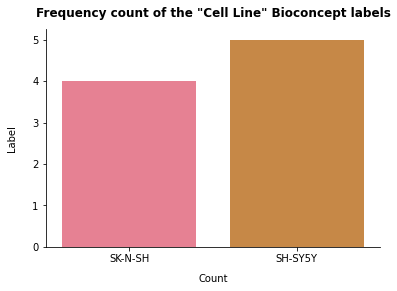

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('husl', 10)

sns.countplot(data=df[df['type'] == 'CellLine'], x='text')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=15)
plt.title('Frequency count of the "Cell Line" Bioconcept labels', fontweight='bold', y=1.03)

sns.despine()

#### 💭 Extra: Exploring the cell lines data
From here, **additional information** could be gathered through other apps, such as [Cellosaurus](https://web.expasy.org/cellosaurus/). There is also an unofficial API we can access through the link below.

```
https://api.cellosaur.us/v34/cell-lines/{identifier}
```

Here we only need to define the **identifier**, which is the name of the cell line.

In [271]:
cell_line_data = df[df['type'] == 'CellLine']
cell_lines = np.unique(cell_line_data['text'])

identifier = cell_lines[0]

base_url = 'https://api.cellosaur.us/v34/cell-lines/'
session = requests.Session()
cellosaurus_response = session.get(base_url + identifier)

print('Available data from Cellousaurus:')

for key in cellosaurus_response.json().keys():
    print(key, end ="; ")

Available data from Cellousaurus:
identifier; accession; synonyms; category; sex; cross-references; reference-identifiers; web-pages; comments; str-profile-data; diseases; species-of-origin; hierarchy; entry-date; 

Let's say we want to know if the **category of the cell line** was whether it was **derived from another line**. We can go through the JSON file and search for these keys, printing the corresponding values.

In [303]:
for identifier in cell_lines:
    session = requests.Session()
    cellosaurus_response = session.get(base_url + identifier)
    cell_data = cellosaurus_response.json()
    category = cell_data['category']
    
    if 'hierarchy' in cell_data.keys():
        hierarchy = cell_data['hierarchy'][0]['derived-from']
        
        print(f'{identifier} ({category}): Derived from {hierarchy}')
        
    else:
        print(f'{identifier} ({category}): Not derived from another cell line.')

SH-SY5Y (Cancer cell line): Derived from SK-N-SH
SK-N-SH (Cancer cell line): Not derived from another cell line.


### Genes
**Genes can be analyzed in a similar way to cell lines**. In this case, we will simply consider genes that appear in more than 5 annotations, as there are many distinct genes in our DataFrame.

Number of distinct genes 128


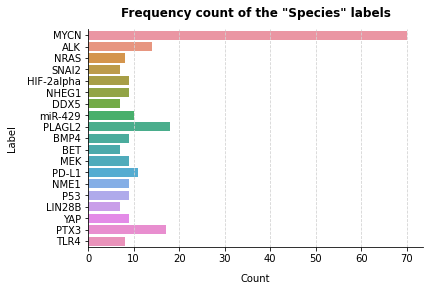

In [437]:
genes = df[df['type'] == 'Gene']

gene_number = len(np.unique(genes["text"]))
print(f'Number of distinct genes {gene_number}')

sub_df = genes[genes.groupby('text').text.transform('count')>5].copy() 
sns.countplot(data=sub_df, y='text')

plt.grid(axis='x', c='lightgrey', linestyle='--')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.title('Frequency count of the "Species" labels', fontweight='bold', y=1.03)

sns.despine()

#### 💭 Extra: Exploring genetics data

In [394]:
search = Entrez.efetch(id=['4613', '238', '4893'], db ='gene', retmode='xml')
gene_properties = Entrez.read(search)

In [313]:
for entry in gene_properties:
    print(entry.get('Entrezgene_type').attributes['value'])

protein-coding
protein-coding
protein-coding


In [ ]:
gene_properties = Entrez.read(search)[0]['Entrezgene_properties'][0]
if 'Gene-commentary_properties' in gene_properties.keys():
    name = gene_properties['Gene-commentary_properties'][0]['Gene-commentary_text']
else:
    name = 'null'

In [431]:
for entry in gene_properties[0]['Entrezgene_properties'][2]['Gene-commentary_comment'][0]['Gene-commentary_comment']:
    print(entry['Gene-commentary_source'][0]['Other-source_anchor'])

DNA binding
DNA-binding transcription activator activity, RNA polymerase II-specific
DNA-binding transcription factor activity
DNA-binding transcription factor activity, RNA polymerase II-specific
DNA-binding transcription factor activity, RNA polymerase II-specific
RNA polymerase II cis-regulatory region sequence-specific DNA binding
RNA polymerase II cis-regulatory region sequence-specific DNA binding
kinase binding
protein binding
protein dimerization activity
sequence-specific double-stranded DNA binding


### Chemicals
Here we can do something similar to the previous two cases.

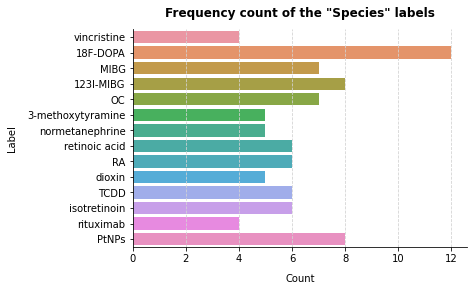

In [449]:
chemicals = df[df['type'] == 'Chemical'].copy()

#hemicals = chemicals[chemicals['identifier'] != '-']

sub_df = chemicals[chemicals.groupby('text').text.transform('count') > 3].copy() 
sns.countplot(data=sub_df, y='text')

plt.grid(axis='x', c='lightgrey', linestyle='--')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.title('Frequency count of the "Species" labels', fontweight='bold', y=1.03)

sns.despine()

### Species
When dealing with cell lines and genes, we could use the text of the annotations, as each cell line has a quite distinctive name. However, **when it comes to other types of data such as diseases and species, some duplications may occur**. 

In [164]:
# Print out some data
number_of_annotations = df['text'].count()
print('Total number of annotations:', number_of_annotations)

unique_text = np.unique(df['text'])
print('Unique text:', len(unique_text))

unique_identifiers = np.unique(df['identifier'])
print('Unique identifiers:', len(unique_identifiers))

Total number of annotations: 1359
Unique text: 342
Unique identifiers: 199


There are only 199 unique identifiers, yet there are 342 distinct text entries. This means that some of these text values are being considered different, even though their identifier is the same. 

Let's see **how the data is grouped based on text.**

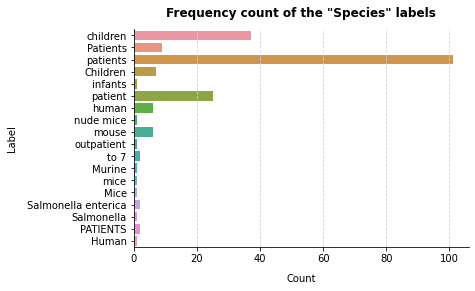

In [185]:
species = df[df['type'] == 'Species']

sns.countplot(data=species, y='text')

plt.grid(axis='x', c='lightgrey', linestyle='--')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.title('Frequency count of the "Species" labels', fontweight='bold', y=1.03)

sns.despine()

Indeed, **grouping our data based on text can lead to some problems**. There are clearly duplicated entries, such as "patients" and "patient" and even "Patient" and "Patients". Furthermore, "children" and "infants" are similar, and "children" could even be grouped into the "patient"/"human" category.

This is where the **identifiers** become relevant. PubTator already assigns a general biomedical identifier to each term, to avoid these problems. For instance, **all of the categories mentioned previously ("patient", "children" and "human") are grouped into the TaxID identifier 9606**, which stands for "Human".

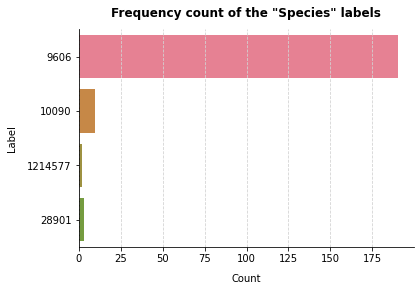

In [186]:
species = df[df['type'] == 'Species']

sns.countplot(data=species, y='identifier')

plt.grid(axis='x', c='lightgrey', linestyle='--')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.title('Frequency count of the "Species" labels', fontweight='bold', y=1.03)

sns.despine()

Now our data is classified into categories! **But... what do these numbers actually mean?** These are TaxIDs, but, to everyone who is not a biologist, they do not mean much. We need to convert them to the actual name of the species, which can be done through `Entrez`.

Additionally, we can build a **local dictionary** to avoid having to connect to the API each time we need to classify an identifier.

In [379]:
species = df[df['type'] == 'Species'].copy()
identifiers = np.unique(species['identifier'])

tax_common_dict = {}
tax_sci_dict = {}

search = Entrez.efetch(id=identifiers, db='taxonomy', retmode='xml')
response = Entrez.read(search)

for entry, original_id in zip(response, identifiers):
    scientific_name = entry.get('ScientificName')
    common_name = entry.get('OtherNames').get('GenbankCommonName')
    print(f'{original_id}: {scientific_name} ({common_name})')
    
    tax_common_dict[original_id] = common_name
    tax_sci_dict[original_id] = scientific_name

10090: Mus musculus (house mouse)
1214577: Diaporthe sclerotioides (None)
28901: Salmonella enterica (None)
9606: Homo sapiens (human)


Finally, let's **recreate the count plots** for the species data, using the common/scientific names instead of the identifiers.

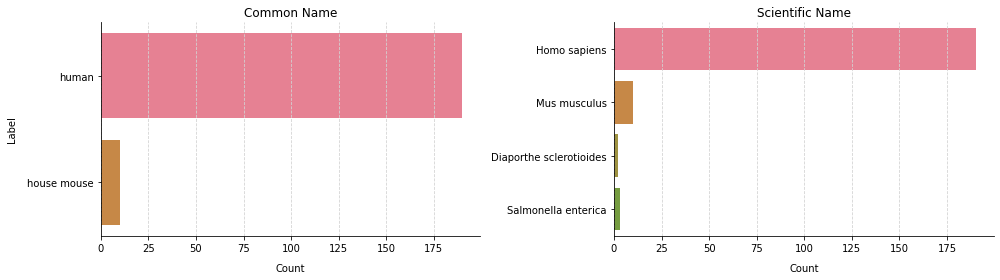

In [393]:
species['common_name'] = None
species['scientific_name'] = None

for row in species.index:
    identifier = species.loc[row]['identifier']
    species.at[row, 'common_name'] = tax_common_dict[identifier]
    species.at[row, 'scientific_name'] = tax_sci_dict[identifier]
    
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
sns.countplot(data=species, y='common_name', ax=axes[0])
sns.countplot(data=species, y='scientific_name', ax=axes[1])

axes[0].set_title('Common Name')
axes[1].set_title('Scientific Name')

for i, ax in enumerate(axes):
    ax.grid(axis='x', c='lightgrey', linestyle='--')

    ax.set_xlabel('Count', labelpad=10)
    
    if i == 0:
        ax.set_ylabel('Label', labelpad=10)
    else:
        ax.set_ylabel('')

sns.despine(fig)
plt.tight_layout()

### Diseases

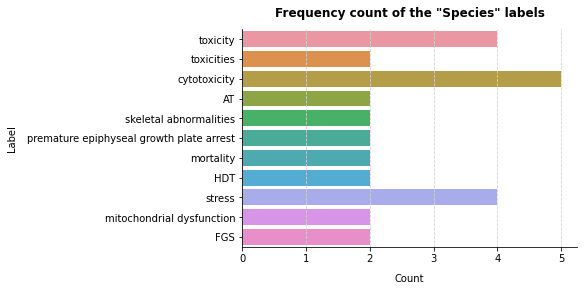

In [472]:
diseases = df[df['type'] == 'Disease']
diseases = diseases[diseases['identifier'] != 'MESH:D009447']
diseases = diseases[diseases['identifier'] != 'MESH:D009369']
diseases = diseases[diseases['identifier'] != 'MESH:D009362']

sub_df = diseases[diseases.groupby('text').text.transform('count') > 1].copy() 
sns.countplot(data=sub_df, y='text')

plt.grid(axis='x', c='lightgrey', linestyle='--')

plt.xlabel('Count', labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.title('Frequency count of the "Species" labels', fontweight='bold', y=1.03)

sns.despine()

In [464]:
identifiers = np.unique(diseases['identifier'])

base_url = 'https://id.nlm.nih.gov/mesh/lookup/details?descriptor='

for identifier in identifiers:
    url = base_url + identifier.replace('MESH:', '')
    response = requests.get(url)
    if len(response.json()['terms']) > 0:
        terms = response.json()['terms'][0]

        if terms['preferred']:
            identifier_name = terms['label']
        else:
            identifier_name = None

    else:
        identifier_name = None
        
    if identifier_name != None:
        print(identifier, identifier_name)

MESH:C537923 Opitz-Kaveggia syndrome
MESH:C538496 Dilated cardiomyopathy, neutropenia, skeletal myopathy, and abnormal mitochondria
MESH:C565785 Epilepsy, Partial, with Variable Foci
MESH:D000079225 Psychological Distress
MESH:D001201 Ascites
MESH:D001523 Mental Disorders
MESH:D001855 Bone Marrow Diseases
MESH:D001919 Bradycardia
MESH:D002292 Carcinoma, Renal Cell
MESH:D003643 Death
MESH:D005729 Ganglioneuroma
MESH:D005767 Gastrointestinal Diseases
MESH:D005909 Glioblastoma
MESH:D006323 Heart Arrest
MESH:D006934 Hypercalcemia
MESH:D007037 Hypothyroidism
MESH:D007239 Infections
MESH:D007247 Infertility, Female
MESH:D007674 Kidney Diseases
MESH:D007676 Kidney Failure, Chronic
MESH:D008171 Lung Diseases
MESH:D008223 Lymphoma
MESH:D009140 Musculoskeletal Diseases
MESH:D009362 Neoplasm Metastasis
MESH:D009369 Neoplasms
MESH:D009503 Neutropenia
MESH:D010235 Paraganglioma
MESH:D010673 Pheochromocytoma
MESH:D010996 Pleural Effusion
MESH:D012516 Osteosarcoma
MESH:D014777 Virus Diseases
MESH:D01